<a href="https://colab.research.google.com/github/Salman1450/CXR-and-MRI/blob/main/MRI_BT_Classification_GAP_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.applications import vgg16
from tensorflow.keras.optimizers import Adam, SGD
import scipy  #Used to upsample our image

import os
import cv2
from PIL import Image
import numpy as np
from scipy import ndimage as nd #For Gaussian Filter

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
image_directory = '/content/drive/MyDrive/Nickparver_156MB/Training/'
SIZE = 224
dataset = []  #Many ways to handle data, you can use pandas. Here, we are using a list format.  
label = []  #Placeholders to define add labels. We will add [0,1,2,3] to [glioma,meningioma,no tumor,pituitary]

In [4]:
glioma_images = os.listdir(image_directory + 'glioma/')
for i, image_name in enumerate(glioma_images):    
    
    if (image_name.split('.')[1] == 'jpg'):
        image = cv2.imread(image_directory + 'glioma/' + image_name)
        image = Image.fromarray(image, 'RGB')
        image = image.resize((SIZE, SIZE))
        image = nd.gaussian_filter(image, sigma=1)
        dataset.append(np.array(image))
        label.append(0)



meningioma_images = os.listdir(image_directory + 'meningioma/')
for i, image_name in enumerate(meningioma_images):
    if (image_name.split('.')[1] == 'jpg'):
        image = cv2.imread(image_directory + 'meningioma/' + image_name)
        image = Image.fromarray(image, 'RGB')
        image = image.resize((SIZE, SIZE))
        image = nd.gaussian_filter(image, sigma=1)
        dataset.append(np.array(image))
        label.append(1)

notumor_images = os.listdir(image_directory + 'notumor/')
for i, image_name in enumerate(notumor_images):
    if (image_name.split('.')[1] == 'jpg'):
        image = cv2.imread(image_directory + 'notumor/' + image_name)
        image = Image.fromarray(image, 'RGB')
        image = image.resize((SIZE, SIZE))
        image = nd.gaussian_filter(image, sigma=1)
        dataset.append(np.array(image))
        label.append(2)

pituitary_images = os.listdir(image_directory + 'pituitary/')
for i, image_name in enumerate(pituitary_images):
    if (image_name.split('.')[1] == 'jpg'):
        image = cv2.imread(image_directory + 'pituitary/' + image_name)
        image = Image.fromarray(image, 'RGB')
        image = image.resize((SIZE, SIZE))
        image = nd.gaussian_filter(image, sigma=1)
        dataset.append(np.array(image))
        label.append(3)

In [5]:
dataset = np.array(dataset)
label = np.array(label)

In [6]:
#Split into train and test data sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(dataset, label, test_size = 0.20, random_state = 0)

In [7]:
#Let us setup the model as multiclass with total classes as 4.
#This way the model can be used for other multiclass examples. 
#Since we will be using categorical cross entropy loss, we need to convert our Y values to categorical. 
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [9]:
#Define the model. 
#Here, we use pre-trained VGG16 layers and add GlobalAveragePooling and dense prediction layers.
 
#Also, here we set the first few convolutional blocks as non-trainable and only train the last block.
#This is just to speed up the training. You can train all layers if you want. 
def get_model(input_shape = (SIZE,SIZE,3)):
    
    vgg = vgg16.VGG16(weights='imagenet', include_top=False, input_shape = input_shape)

    
    for layer in vgg.layers[:-5]:    #Set block5 trainable, all others as non-trainable
        print(layer.name)
        layer.trainable = False #All others as non-trainable.

    x = vgg.output
    x = GlobalAveragePooling2D()(x) #Use GlobalAveragePooling and NOT flatten. 
    x = Dense(4, activation="softmax")(x)  #We are defining this as multiclass problem. 

    model = Model(vgg.input, x)
    model.compile(loss = "categorical_crossentropy", 
                  optimizer = SGD(learning_rate=0.0001, momentum=0.9), metrics=["accuracy"])
    
    return model

model = get_model(input_shape = (224,224,3))
print(model.summary())

input_2
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_pool
block4_conv1
block4_conv2
block4_conv3
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Co

In [10]:
history = model.fit(X_train, y_train, batch_size=16, epochs=10, verbose = 1, 
                    validation_data=(X_test,y_test))

Epoch 1/10
286/286 [==============================] - 40s 122ms/step - loss: 0.4335 - accuracy: 0.8531 - val_loss: 0.2483 - val_accuracy: 0.9195
Epoch 2/10
286/286 [==============================] - 28s 98ms/step - loss: 0.1452 - accuracy: 0.9543 - val_loss: 0.1868 - val_accuracy: 0.9414
Epoch 3/10
286/286 [==============================] - 28s 97ms/step - loss: 0.0855 - accuracy: 0.9755 - val_loss: 0.2181 - val_accuracy: 0.9230
Epoch 4/10
286/286 [==============================] - 28s 96ms/step - loss: 0.0508 - accuracy: 0.9869 - val_loss: 0.1576 - val_accuracy: 0.9554
Epoch 5/10
286/286 [==============================] - 28s 99ms/step - loss: 0.0279 - accuracy: 0.9961 - val_loss: 0.1457 - val_accuracy: 0.9606
Epoch 6/10
286/286 [==============================] - 28s 98ms/step - loss: 0.0188 - accuracy: 0.9980 - val_loss: 0.1461 - val_accuracy: 0.9624
Epoch 7/10
286/286 [==============================] - 28s 98ms/step - loss: 0.0132 - accuracy: 0.9989 - val_loss: 0.1451 - val_accuracy

In [11]:
#Check model accuracy on the test data
_, acc = model.evaluate(X_test, y_test)
print("Accuracy = ", (acc * 100.0), "%")

36/36 [==============================] - 10s 197ms/step - loss: 0.1470 - accuracy: 0.9650
Accuracy =  96.50043845176697 %


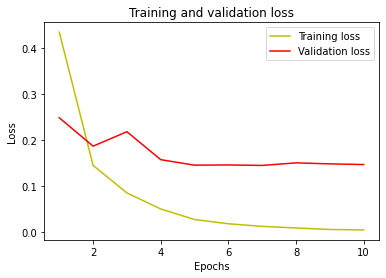

In [12]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

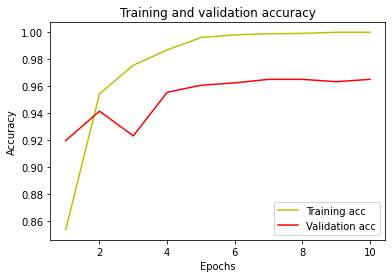

In [13]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

1/1 [==============================] - 1s 1s/step
The prediction for this image is:  0
The actual label for this image is:  0


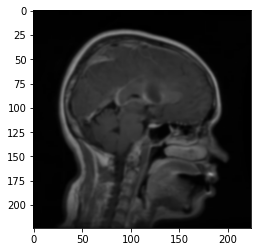

In [14]:
#Test on single image.
n=100  #Select the index of image to be loaded for testing
img = X_test[n]
plt.imshow(img)
input_img = np.expand_dims(img, axis=0) #Expand dims so the input is (num images, x, y, class)
print("The prediction for this image is: ", np.argmax(model.predict(input_img)))
print("The actual label for this image is: ", np.argmax(y_test[n]))

1/1 [==============================] - 0s 20ms/step
The prediction for this image is:  3


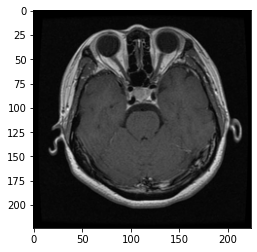

In [15]:
#Test on single image from other sources.
  
img = '/content/drive/MyDrive/Nickparver_156MB/Testing/pituitary/Te-pi_0011.jpg'
image = cv2.imread(img)
image = Image.fromarray(image, 'RGB')
image = image.resize((SIZE, SIZE))
plt.imshow(image)
input_img = np.expand_dims(image, axis=0) #Expand dims so the input is (num images, x, y, class)
print("The prediction for this image is: ", np.argmax(model.predict(input_img)))#0_Glioma,1_Meningioma, 2_NT, 3_Pit


36/36 [==============================] - 5s 134ms/step


[Text(0, 0.5, 'glioma'),
 Text(0, 1.5, 'meningioma'),
 Text(0, 2.5, 'no_tumor'),
 Text(0, 3.5, 'pituitary')]

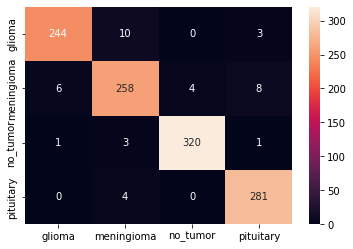

In [16]:
#Print confusion matrix for Validation Set
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

y_pred = np.argmax(model.predict(X_test), axis=1)
cm=confusion_matrix(np.argmax(y_test, axis=1), y_pred)  
ax = sns.heatmap(cm, annot=True, fmt = 'd')
ax.xaxis.set_ticklabels(['glioma', 'meningioma','no_tumor', 'pituitary'])
ax.yaxis.set_ticklabels(['glioma', 'meningioma','no_tumor', 'pituitary']) 

In [17]:
#Classifiction Report For Validation Set Only
classification_report = classification_report(np.argmax(y_test, axis=1), y_pred, target_names=['glioma', 'meningioma','no_tumor', 'pituitary'])
print(classification_report)

              precision    recall  f1-score   support

      glioma       0.97      0.95      0.96       257
  meningioma       0.94      0.93      0.94       276
    no_tumor       0.99      0.98      0.99       325
   pituitary       0.96      0.99      0.97       285

    accuracy                           0.97      1143
   macro avg       0.96      0.96      0.96      1143
weighted avg       0.97      0.97      0.96      1143



# **Test Set**

In [18]:
#Results on Test Set

new_data_directory = '/content/drive/MyDrive/Nickparver_156MB/Testing/'

SIZE = 224
new_dataset = []  #Many ways to handle data, you can use pandas. Here, we are using a list format.  
new_label = []  #Placeholders to define add labels. We will add [0,1,2,3] to [glioma,meningioma,no tumor,pituitary]

In [20]:
glioma_images = os.listdir(new_data_directory + 'glioma/')
for i, image_name in enumerate(glioma_images):    
    
    if (image_name.split('.')[1] == 'jpg'):
        image = cv2.imread(new_data_directory + 'glioma/' + image_name)
        image = Image.fromarray(image, 'RGB')
        image = image.resize((SIZE, SIZE))
        image = nd.gaussian_filter(image, sigma=1)
        new_dataset.append(np.array(image))
        new_label.append(0)



meningioma_images = os.listdir(new_data_directory + 'meningioma/')
for i, image_name in enumerate(meningioma_images):
    if (image_name.split('.')[1] == 'jpg'):
        image = cv2.imread(new_data_directory + 'meningioma/' + image_name)
        image = Image.fromarray(image, 'RGB')
        image = image.resize((SIZE, SIZE))
        image = nd.gaussian_filter(image, sigma=1)
        new_dataset.append(np.array(image))
        new_label.append(1)

notumor_images = os.listdir(new_data_directory + 'notumor/')
for i, image_name in enumerate(notumor_images):
    if (image_name.split('.')[1] == 'jpg'):
        image = cv2.imread(new_data_directory + 'notumor/' + image_name)
        image = Image.fromarray(image, 'RGB')
        image = image.resize((SIZE, SIZE))
        image = nd.gaussian_filter(image, sigma=1)
        new_dataset.append(np.array(image))
        new_label.append(2)

pituitary_images = os.listdir(new_data_directory + 'pituitary/')
for i, image_name in enumerate(pituitary_images):
    if (image_name.split('.')[1] == 'jpg'):
        image = cv2.imread(new_data_directory + 'pituitary/' + image_name)
        image = Image.fromarray(image, 'RGB')
        image = image.resize((SIZE, SIZE))
        image = nd.gaussian_filter(image, sigma=1)
        new_dataset.append(np.array(image))
        new_label.append(3)

In [21]:
new_dataset = np.array(new_dataset)
new_label = np.array(new_label)

In [26]:
from sklearn.model_selection import train_test_split
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(new_dataset, new_label, test_size = 0.999, random_state = 0)

In [27]:
#Session crashed without train_test_split
#y_train = to_categorical(y_train)
#y_test = to_categorical(y_test)
from tensorflow.keras.utils import to_categorical
y_train_new = to_categorical(y_train_new)
y_test_new = to_categorical(y_test_new)

In [28]:
print(y_test_new.shape)

(1310, 4)


In [29]:
#Check model accuracy on the test data
#_, acc = model.evaluate(X_test, y_test)
#print("Accuracy = ", (acc * 100.0), "%")
_, acc = model.evaluate(X_test_new, y_test_new)
print("Accuracy = ", (acc * 100.0), "%")

41/41 [==============================] - 9s 209ms/step - loss: 0.1133 - accuracy: 0.9710
Accuracy =  97.0992386341095 %


41/41 [==============================] - 6s 139ms/step


[Text(0, 0.5, 'glioma'),
 Text(0, 1.5, 'meningioma'),
 Text(0, 2.5, 'no_tumor'),
 Text(0, 3.5, 'pituitary')]

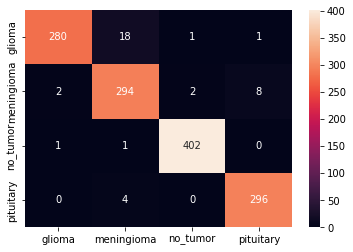

In [30]:
#Print confusion matrix for Test Set
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

y_pred_new = np.argmax(model.predict(X_test_new), axis=1)
cm=confusion_matrix(np.argmax(y_test_new, axis=1), y_pred_new)  
ax = sns.heatmap(cm, annot=True, fmt = 'd')
ax.xaxis.set_ticklabels(['glioma', 'meningioma','no_tumor', 'pituitary'])
ax.yaxis.set_ticklabels(['glioma', 'meningioma','no_tumor', 'pituitary']) 

In [31]:
#Classifiction Report for Test Set
classification_report = classification_report(np.argmax(y_test_new, axis=1), y_pred_new, target_names=['glioma', 'meningioma','no_tumor', 'pituitary'])
print(classification_report)

              precision    recall  f1-score   support

      glioma       0.99      0.93      0.96       300
  meningioma       0.93      0.96      0.94       306
    no_tumor       0.99      1.00      0.99       404
   pituitary       0.97      0.99      0.98       300

    accuracy                           0.97      1310
   macro avg       0.97      0.97      0.97      1310
weighted avg       0.97      0.97      0.97      1310

